In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
%matplotlib inline

In [39]:
import therpy as tp 
divide_axes = tp.divide_axes
sdict = tp.sdict

# Prior to 12/21/2019

In [3]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - I think this could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000)
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")

        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):fitfun.__code__.co_argcount], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err

        ### Plots and display
        if plot: self.plot()
        if info: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): return np.linspace(self.x.min(), self.x.max(), 1000)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if x is None: x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if x is None: x = self.xp
        if ax is None: fig, ax = plt.subplots()
        ax.errorbar(self.x, self.y, self.y_err, fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        ax.plot(self.x, self.y-self(), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if x is None: x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        if x is None: x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)

# 12/21/2019

In [53]:
'''
curve fitting
=============
'''
class curve_fit:
    '''
    Least square curve fitting to {x,y} data
    ========================================
    Inputs Required :
        fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data
        guess  - could be a simple list, or more detailed dict (see below for more info)
        x_data - This could be anything supported by fitfun input, to be safe, keep it np.array
        y_data - must be np.array

    Inputs Optional :
        y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
        fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed
        plot  - True / False : Plots a standard figure with data, fit line, residuals
        info  - True / False : print(self.fr)
        disp  - True / False : print(self.fr), info or disp are identical 

    guess :
        1) guess = [12, 3, -np.pi, ...] : a simple list
        2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list
        A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
        A fancy list must contain the guess itself, but the other two things are optional
        3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list

    MUST DO :
        - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan.

    Properties : self.xxxxxx
        x, y, y_err, success, fitfun
        fr : pandas dataframe of the fitresults
        fv : indexable sdict of fit values with parameters as keys, including the fixed and default parameters
        fe : indexable sdict of fit errors with parameters as keys, including the fixed and default parameters
        ul : indexable sdict of upper limit of fit values with parameters as keys, including the fixed and default parameters
        ll : indexable sdict of lower limit of fit values with parameters as keys, including the fixed and default parameters
        xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000), if fitfun allows
        ye : short form for y_err

    Special Methods :
        __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp),
        __len__ : len(self) returns the number of parameters the fitfun takes
        __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index
        __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the
        __bool__ : if self: or bool(self) : true if the fit was successful
        __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format

    Methods : self.xxx(aa=yy, bb=yy, ..)
        yband(x = None, using=[]) :
        plot()
            two plots, data and fit curve on top, and residuals below. Optional inputs
            ax : to plot somewhere specific
            fiterrors = False : include fit error band along with optimal fit
            using = [] : which parameters to sue to calculate fiterrors band
            divider = 0.25 : how to split the axes for residuals
        plot_fitdata(ax=None, x=None) : data and fit curve
        plot_residuals(ax=None) : residuals
        plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals
        plot_fiterrors(ax=None, x=None, using=[]) : fit error band, optinally include only keys in using
    '''
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False, disp=False):
        ''' init will fit the data and save fitresults '''
        ### Verify inputs
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        # If y_err is not provided, set it to some small number, smaller than the smallers of y
        if y_err == None: y_err = np.ones_like(x_data)*np.min(np.abs(y_data))/100000 
        
        ### Process single item from guess -- return guess value, bounds, units
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]

        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units
        # the order of keys will be determined by the order of fitfun input order
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]

        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):fitfun.__code__.co_argcount], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)

        ### Define temp fitfun for internal use only
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)

        ### Fit Data
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err:
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))

        ### Formatting Fit Results
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:fitfun.__code__.co_argcount], :] # sort the index by function input list
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100

        ### Store results to self
        self.fr = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err

        ### Plots and display
        if plot: self.plot()
        if info or disp: print(self)

    @property
    def fv(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values))
    @property
    def fe(self): return sdict(zip(self.fr.index.values, self.fr['FitError'].values))
    @property
    def ul(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values + self.fr['FitError'].values))
    @property
    def ll(self): return sdict(zip(self.fr.index.values, self.fr['FitValue'].values - self.fr['FitError'].values))
    @property
    def xp(self): 
        xp = np.linspace(self.x.min(), self.x.max(), 1000)
        # If the function always returns a fixed length output independent of the x input 
        if len(self.y) == len(self(xp)): xp = self.x
        return xp
    @property
    def yp(self): return self(self.xp)
    @property
    def ye(self): return self.y_err

    def __call__(self, *args, **kwargs):
        '''get the fit line evaluated at *args (self.x) with **kwargs overridden'''
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fv, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key):
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fv.get(key, None)
    def __setitem__(self, key, value):
        if type(key) in [int, float]: key = self.fr.index.values[int(key)]
        r = self.fr.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fr.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fr.to_string()
    def __str__(self): return self.fr.to_string()

    def yband(self, x=None, using=[]):
        '''Return (y_min, y_max) at x including using list of fit errors'''
        if x is None: x = self.x
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fr.index.values
        ys = [self(x)]
        for k in using:
            ys.append(self(x, **{k : self.fv[k] - self.fe[k]}))
            ys.append(self(x, **{k : self.fv[k] + self.fe[k]}))
        return (np.min(ys, axis=0), np.max(ys, axis=0))
    def plot_fitdata(self, ax=None, x=None):
        '''Plot data and the fitline on ax (or new figure) with x (or self.xp) for fitline'''
        if x is None: x = self.xp
        if ax is None: fig, ax = plt.subplots()
        sorti = np.argsort(self.x)
        print(sorti)
        ax.errorbar(self.x[sorti], self.y[sorti], self.y_err[sorti], fmt='r.-')
        ax.plot(x, self(x), 'k')
        return ax
    def plot_residuals(self, ax=None):
        '''Plot residual with vertical lines and zero line on ax (or new figure)'''
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        sorti = np.argsort(self.x)
        ax.plot(self.x[sorti], self.y[sorti]-self()[sorti], 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        '''Plot histogram of the residul on ax (or new figure) with orientation either vertical or horizontal'''
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, x=None, using=[]):
        '''Plot a band of y representing fit errors : on ax (or a new figure) with x (or self.ax) and with using list (or all) of fit variables'''
        if x is None: x = self.xp
        ax = self.plot_fitdata(ax)
        ax.fill_between(x, *self.yband(x=x, using=using), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, x=None, fiterrors=True, using=[], divider=0.25):
        '''Plot data with fitline and '''
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        if x is None: x = self.xp
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax=ax1, x=x, using=using)
        else: self.plot_fitdata(ax=ax1, x=x)
        self.plot_residuals(ax2)
        return (ax1, ax2)
    def bootstrap(self, points=1000, plot=True):
        frs = np.zeros(shape=[points, len()])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
        FitValue  FitError    Units  Guess  LowerBound  UpperBound  FitError%
amp     0.852019  0.072398     arb.   0.50        -1.0    2.000000   8.497219
k       1.002014  0.015652      1/m   1.00         0.0    2.000000   1.562067
phase   4.933902  0.088328  Radians   3.14         0.0    6.283185   1.790220
offset -0.269702  0.052764     arb.   0.00        -1.0    1.000000  19.563657
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


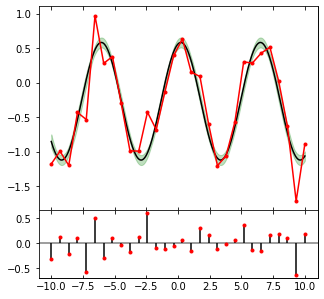

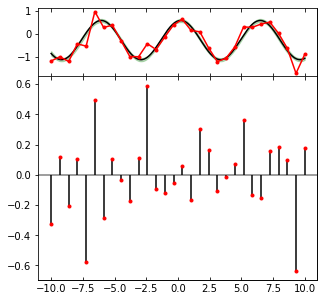

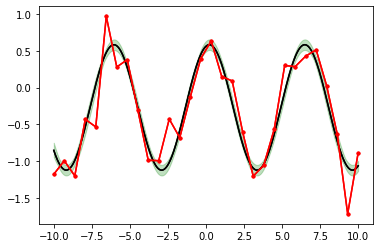

In [62]:
# Tests 
x = np.linspace(-10, 10, 30)
y_exact = 0.87654 * np.sin(0.987 * x + 1.2345) - 0.2345
y_measure = y_exact + np.random.normal(loc=0, scale=0.3, size=x.size)

# Define a fitting function 
def fitfun(x, amp=1, k=1, phase=1, offset=0):
    return amp*np.sin(k*x - phase) + offset 
# Guess for the fit 
guess = [0.5, 1, np.pi, 0.2] # Option 1 : list of parameters 
guess = dict(amp=0.5, k=1, phase=np.pi, offset=0) # Option 2 : dict of guess parameters 
guess = dict(amp=[0.5, (-1, 2), "arb."], k=[1, (0, 2), "1/m"], phase=[3.14, (0, 2*np.pi), "Radians"], 
             offset=[0, (-1, 1), 'arb.']) # Option 3 : dict of guess with individual having [guess_value, limits, units]
# Fit results and plot and disp
cf = curve_fit(fitfun, guess, x, y_measure, plot=True, info=True)

# PLots 
cf.plot(fiterrors=True, using=[], divider=0.75)

# Plots 
ax = cf.plot_fitdata()
cf.plot_fiterrors(ax=ax)